In [78]:
%matplotlib inline

In [79]:
import sklearn
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from IPython.display import display, clear_output
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from numpy import zeros
from tqdm.auto import tqdm

In [80]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Введем некоторые константы

In [81]:
NUM_LABELS = 10
SEED = 99
INPUT_DIR = "/content/gdrive/MyDrive/DZ1_NeuralNetwork" # путь до данных для обучения
OUTPUT_FNAME = "MySubmission.csv" # здесь должно быть записано имя выходного файла с ответами модели
CLS_LIST = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat", "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

Загрузим данные для обучения и теста

In [82]:
X_train = np.load(f"{INPUT_DIR}/x_train.npy")
y_train = np.load(f"{INPUT_DIR}/y_train.npy")
X_valid = np.load(f"{INPUT_DIR}/x_test.npy")

In [83]:
len(X_train)

60000

Посмотрим, как выглядят наши данные

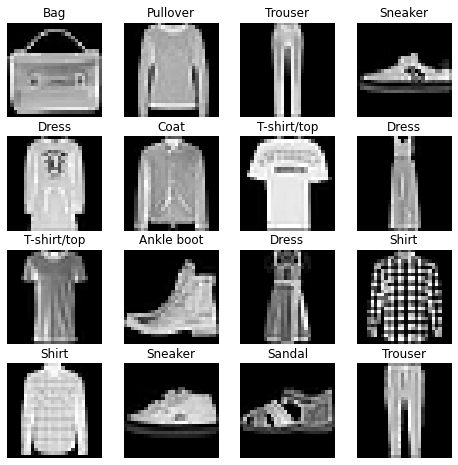

In [84]:
plt.figure(figsize=(8,8))
np.random.seed(SEED)
num_rc = 4
for i in range(16):
    idx = np.random.randint(X_train.shape[0])
    ax = plt.subplot(num_rc, num_rc, i + 1)
    ax.set_title(CLS_LIST[y_train[idx]])
    ax.set_axis_off()
    plt.imshow(X_train[idx].reshape(28,28), cmap='gray', vmin = 0, vmax = 255)

Разделим обучение на train и test

In [85]:
# Необходимо дописать пайплайн разделения данных
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.05, random_state=42)

In [86]:
len(X_train)

57000

Определим классы наших слоев

In [87]:
class Dense:
    def __init__(self, in_size, out_size):
        np.random.seed(1)
        self.W = np.random.normal(scale=0.1, size=(out_size, in_size))
        self.b = np.random.normal(scale=0.1, size=(out_size))
        
    def forward(self, x):
        self.x = x # запоминаем для обратного прохода
        return np.dot(self.W, x) + self.b
    
    def backward(self, dz, lr=0.01):
        # вычисляем градиенты по параметрам (запоминаем их для отладки)
        self.dW = np.outer(dz, self.x)
        self.db = dz
        # вычисляем производную по входу
        self.dx = np.matmul(dz, self.W) 
        # обновляем веса
        self.W = self.W - lr * self.dW
        self.db = self.db - lr * self.db
        # возвращаем dx для продолжения алгоритма
        return self.dx

In [88]:
class ELU:
    def __init__(self, alpha):
        self.alpha = alpha

    def forward(self, x):
        self.x = x  
        return np.where(x > 0, x, self.alpha * (np.exp(x) - 1)) 

    def backward(self, dz, lr=0.001):
        t = np.where(self.x > 0, 0, self.alpha * (np.exp(self.x) - 1))
        dz.put([i for i in range(self.x.shape[0]) if self.x[i] < 0], t[t != 0])
        return dz

In [89]:
class ReLU:
    def forward(self, x):
        self.x = x
        return np.maximum(0, x)
    
    def backward(self, dz, lr=0.001):
        dz[self.x < 0] = 0
        return dz

In [90]:
class Softmax:
    def forward(self, x):
        self.x = x
        exps = np.exp(x - np.max(x))
        return exps / np.sum(exps)
        
    
    def backward(self, dz, lr=0.001):
        sm = self.forward(self.x)
        self.lp = (np.eye(sm.shape[0], sm.shape[0]) - sm).T
        self.lp2 = sm * self.lp
        return np.dot(dz, self.lp2)

In [91]:
class CrossEntropy:
    def forward(self, y_true, y_hat):
        self.y_true = y_true
        self.y_hat = y_hat
        return -np.sum( y_true * np.log(y_hat))
    
    def backward(self, dz, lr=0.001):
        return dz * -1. * self.y_true / self.y_hat

Соберем сеть для классификации изображений

In [92]:
class FashionMnistNet:
  def __init__(self):
    self.a1 = ReLU()
    self.a2 = ReLU()
    self.a3 = ReLU()
    self.a4 = ReLU()
    self.d1 = Dense(784, 128)
    self.d2 = Dense(128, 128)
    self.d3 = Dense(128, 128)
    self.d4 = Dense(128, 128)
    self.d5 = Dense(128, 10)
    self.sm = Softmax()
    
  def forward(self, x):
    net = self.d1.forward(x)
    net = self.a1.forward(net)
    net = self.d2.forward(net)
    net = self.a2.forward(net)
    net = self.d3.forward(net)
    net = self.a3.forward(net)
    net = self.d4.forward(net)
    net = self.a4.forward(net)
    net = self.d5.forward(net)
    net = self.sm.forward(net)
    self.net = net
    return net

  def backward(self, dz, lr=0.001):
    dz = self.sm.backward(dz, lr)
    dz = self.d5.backward(dz, lr)
    dz = self.a4.backward(dz, lr)
    dz = self.d4.backward(dz, lr)
    dz = self.a3.backward(dz, lr)
    dz = self.d3.backward(dz, lr)
    dz = self.a2.backward(dz, lr)
    dz = self.d2.backward(dz, lr)
    dz = self.a1.backward(dz, lr)
    dz = self.d1.backward(dz, lr)
    return dz

Предобработаем наши данные

In [93]:
# тут необходимо дописать базовую предобработку датасета
scaler = MinMaxScaler()
Xt_train_mod = scaler.fit_transform(X_train)
Xt_test_mod = scaler.fit_transform(X_test)
X_valid_mod = scaler.fit_transform(X_valid)

In [94]:
# заэнкодим наши ответы
t = OneHotEncoder(sparse=False)
yt_train_oh = t.fit_transform(y_train.reshape(-1, 1))
yt_test_oh = t.fit_transform(y_test.reshape(-1, 1))

In [95]:
net = FashionMnistNet()

  0%|          | 0/1000 [00:00<?, ?it/s]

Выходные данные были обрезаны до нескольких последних строк (5000).
Accuracy:  0.878
############################################################
Loss at train in  167  epoch
0.008494276310589232
Loss at test in  167  epoch
0.34006460380068065
Accuracy:  0.8763333333333333
############################################################
Loss at train in  168  epoch
0.008410003126549494
Loss at test in  168  epoch
0.3407374486079156
Accuracy:  0.878
############################################################
Loss at train in  169  epoch
0.007975343984293903
Loss at test in  169  epoch
0.35011406488606145
Accuracy:  0.8716666666666667
############################################################
Loss at train in  170  epoch
0.008401133460742258
Loss at test in  170  epoch
0.32749349207262624
Accuracy:  0.8796666666666667
############################################################
Loss at train in  171  epoch
0.00861249485478777
Loss at test in  171  epoch
0.3231615842182642
Accuracy:  0.886

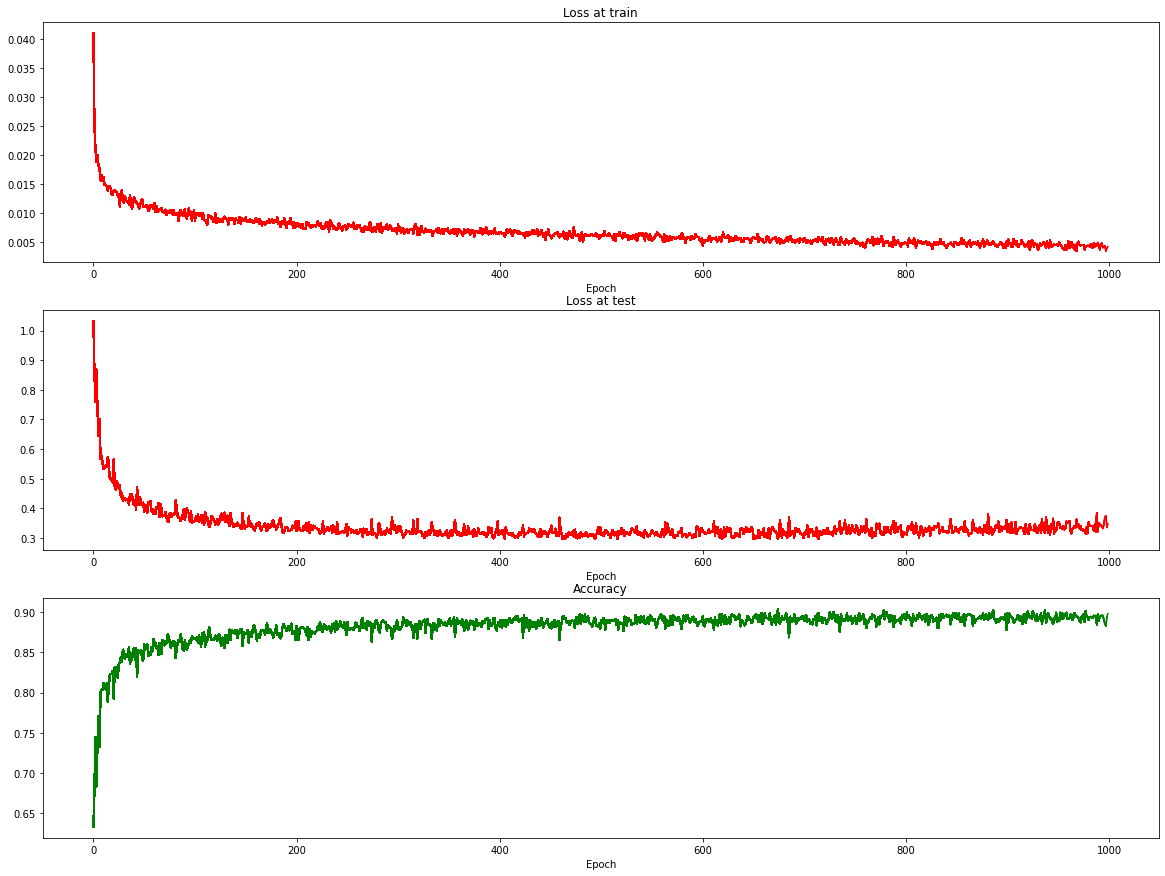

In [96]:
np.random.seed(SEED)
NUM_EPOCH = 1000
learning_rate = 0.001
L_train_acc = [] # массив для хранения лоссов на обучении за эпоху
L_test_acc = [] # массив для хранения лоссов на отложенном сете
Acc_test_acc = [] # массив для хранения точности на отложенном сете за эпоху

loss = CrossEntropy()

Acc_to_stop = 0.91

fig = plt.figure(figsize=(20, 15))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)

for epoch in tqdm(range(NUM_EPOCH)):

    # ЧАСТЬ 1:
    # проводим эпоху обучения, сохраняем средний лосс по всем примерам за эпоху
    # в переменной L_train_acc

    L_acc = 0.
    sh = list(range(Xt_train_mod.shape[0]))
    np.random.shuffle(sh)
    sh = sh[:1500]
    for i in range(len(sh)):
        x = Xt_train_mod[sh[i]]
        y = yt_train_oh[sh[i]]
        y_h = net.forward(x)
        L = loss.forward(y, y_h)
        L_acc += L
        dz = loss.backward(1, learning_rate)
        dz = net.backward(dz, learning_rate)
    L_train_acc.append(L_acc / Xt_train_mod.shape[0])
    print("Loss at train in ", epoch, " epoch")
    print(L_train_acc[-1])

    # ЧАСТЬ 2:
    # Оцениваем сеть после одной эпохи на отложенной выборке
    # Сохраняем средний лосс в переменной L_test_acc
    # Сохраняем среднее значение accuracy в Acc_test_acc

    L_acc = 0.
    temp = 0.
    for i in range(Xt_test_mod.shape[0]):
      x = Xt_test_mod[i]
      y = yt_test_oh[i]
      y_h = net.forward(x)
      L = loss.forward(y, y_h)
      L_acc += L
      temp += int(y_test[i] == np.argmax(y_h))
    L_test_acc.append(L_acc / Xt_test_mod.shape[0])
    Acc_test_acc.append(temp / Xt_test_mod.shape[0])
 
    # Выводим 2 графика : 
    # 1) Лоссы на трейне и отложенном сете по эпохам
    # 2) Точность(accuracy) по эпохам на отложенном сете

    print("Loss at test in ", epoch, " epoch")
    print(L_test_acc[-1])
    print("Accuracy: ", Acc_test_acc[-1])
    print("#"*60)

    ax1.plot(range(epoch + 1), L_train_acc, 'r-')
    ax1.set_title('Loss at train')
    ax1.set_xlabel('Epoch')
    fig.canvas.draw()
    
    ax2.plot(range(epoch + 1), L_test_acc, 'r-')
    ax2.set_title('Loss at test')
    ax2.set_xlabel('Epoch')
    fig.canvas.draw() 
    
    ax3.plot(range(epoch + 1), Acc_test_acc, 'g-')
    ax3.set_title('Accuracy')
    ax3.set_xlabel('Epoch')
    fig.canvas.draw()

    if(Acc_test_acc[-1] > Acc_to_stop):
        break

In [97]:
# формируем сабмишшен
with open(OUTPUT_FNAME, 'w') as fout: 
    fout.write("Id,Category\n")
    for i, x in tqdm(enumerate(X_valid_mod)):
        n_out = net.forward(x)
        fout.write(f"{i},{np.argmax(n_out, axis=0)}\n")

0it [00:00, ?it/s]